In [116]:
import numpy as np
import matplotlib.pyplot as plt
import math
import fitClus2D as fc
from scipy.stats import sigmaclip

import pandas as pd

catalog = pd.read_csv('Files/a2744_master.csv')

print(catalog.describe())

unknown = []
cluster = []
ncluster = []
clustz = 0.308
cut = 0.03
totdif = 0

for i, row in catalog.iterrows():
    if not np.isnan(row['master_mag606']) and not np.isnan(row['master_mag814']) and row['master_d'] < 120 and row['master_mag814'] < 23.5:
        if np.isnan(row['master_z']):
            if row['master_mag606'] - row['master_mag814'] < 1.1 and row['master_mag606'] - row['master_mag814'] > 0:
                unknown.append(row)
        else:
            if abs(row['master_z'] - clustz) < cut:
                totdif += (row['master_z'] - 0.308) ** 2
                cluster.append(row)
            else:
                ncluster.append(row)

#Clip redshifts
clusterz = np.array([row['master_z'] for row in cluster])
arr, low, high = sigmaclip(clusterz, 3, 3)
tmpclust = []

for row in cluster:
    if row['master_z'] > low and row['master_z'] < high:
        tmpclust.append(row)
    else:
        ncluster.append(row)
    
cluster = tmpclust


#function to scatter plot an array of rows
def getMags(rows):
    return [row['master_mag814'] for row in rows]

def getColors(rows):
    return [row['master_mag606'] - row['master_mag814'] for row in rows]
    #return [row['master_mag606'] for row in rows]
    
def getX(rows):
    return [row['master_x'] for row in rows]

def getY(rows):
    return [row['master_y'] for row in rows]

def scatterCM(rows, c):
    x = np.array(getMags(rows))
    y = np.array(getColors(rows))
    plt.scatter(x, y, color = c)


          master_RA    master_Dec     master_z     owers_RA    owers_Dec  \
count  41431.000000  41431.000000  1378.000000  1250.000000  1250.000000   
mean       3.582321    -30.399705     0.439693     3.581955   -30.397938   
std        0.196361      0.139591     0.361527     0.131543     0.108262   
min        3.235287    -30.642775     0.008695     3.296875   -30.639371   
25%        3.418619    -30.518818     0.295505     3.489865   -30.481049   
50%        3.578819    -30.398252     0.312739     3.580666   -30.396597   
75%        3.750651    -30.281333     0.481753     3.667250   -30.320785   
max        3.931102    -30.157418     3.980000     3.869875   -30.159917   

        owers_magr      owers_z   owers_zerr  owers_quality    glass_RA  ...  \
count  1250.000000  1250.000000  1250.000000   4.143100e+04  153.000000  ...   
mean     20.275712     0.369176     0.000421  -2.082693e+09    3.587400  ...   
std       0.984663     0.215758     0.000479   3.673458e+08    0.011086  ..

[-0.01842295  1.16892735]


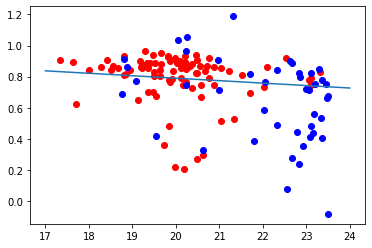

In [117]:

#linear regression for color magnitude diagram of cluster members
clustermag = [row['master_mag814'] for row in cluster]
clustercolor = [row['master_mag606'] - row['master_mag814'] for row in cluster]
model = np.polyfit(clustermag, clustercolor, 1)
a, b = model
predict = np.poly1d(model)
plt.plot([17, 24], [predict(18), predict(24)])


#plot scatters
#scatterCM(unknown, 'green')
scatterCM(cluster, 'red')
scatterCM(ncluster, 'blue')

0.15554118074969264
0.5035383777898745
Read in 336 galaxies


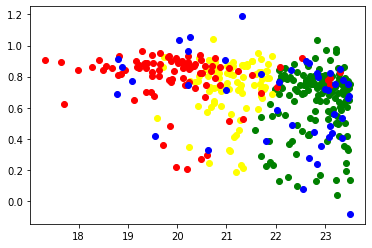

In [118]:
clusterData = [[row['master_x'], row['master_y'], row['master_mag814'], 1] for row in cluster]
unknownData = [[row['master_x'], row['master_y'], row['master_mag814'], 0] for row in unknown]

#set uniform probability for unknowns within n * sigma of relation
def setProbUniform(n):
    global unknownData
    print(sigma)
    p = 1
    for i, row in enumerate(unknown):
        if abs(row['master_mag606'] - row['master_mag814'] - predict(row['master_mag814'])) < n * sigma:
            unknownData[i][3] = p


def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

#Calculate probabilities for unknowns using k nearest neighbors on Color Magnitude diagram
def setProbKnn(k):
    global unknownData
    
    ukn = len(unknown)
    clustn = len(cluster)
    nclustn = len(ncluster)
    
    allmags = getMags(unknown) + getMags(cluster) + getMags(ncluster)
    allcolors = getColors(unknown) + getColors(cluster) + getColors(ncluster)
    
    normmags = np.array(normalize(np.array(allmags)))
    normcolors = np.array(normalize(np.array(allcolors)))
    
    inclust = np.zeros(clustn + nclustn)
    inclust[:clustn] = 1
    dist = np.zeros(clustn + nclustn)
    
    tot = 0
    count = 0
    for i in range(ukn):
        mag1 = normmags[i]
        color1 = normcolors[i]
        
        for j in range(clustn + nclustn):
            mag2 = normmags[ukn + j]
            color2 = normcolors[ukn + j]
            dist[j] = ((mag1 - mag2) ** 2 + (color1 - color2) ** 2) ** 0.5
        
        
        idx = np.argpartition(dist, k)
        
        prev = unknownData[i][3]
        unknownData[i][3] = np.average(inclust[idx[:k]])
        
        if prev == 1:
            tot += unknownData[i][3]
            count += 1
            
        if (unknownData[i][3] < 0.5): c = "green"
        else: c = "yellow"
        plt.scatter(allmags[i], allcolors[i], color = c)
    
    print(tot / count)
    
    
#draw scatter plot of uncertainties in varying cluster members, or in scattering
def scatterDraw(n, vclust, scatter):
    colors = ["blue", "red", "green", "orange"]
    alldeflect = []
    for i in range(n):
        gal.draw(vclust, scatter)
        deflect, gamma = gal.calcdefbasic(images)
        alldeflect.append(deflect)

    alldeflect = np.array(alldeflect)
    for i in range(len(images)):
        x = alldeflect[:,i,0]
        y = alldeflect[:,i,1]
        plt.scatter(x, y, color = colors[i])
        
            
#Plot scatter plots of uncertainties
setProbUniform(1)
setProbKnn(11)

scatterCM(cluster, 'red')
scatterCM(ncluster, 'blue')

data = clusterData + unknownData
gal = fc.galclass(data)
gal.scale()

images = np.array([[20, 25], [-13, 26], [-1, 2]])


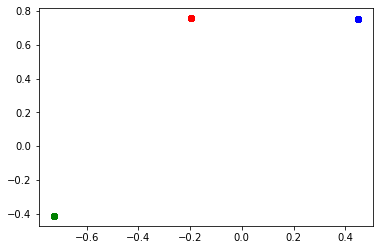

In [89]:
scatterDraw(100, False, False)

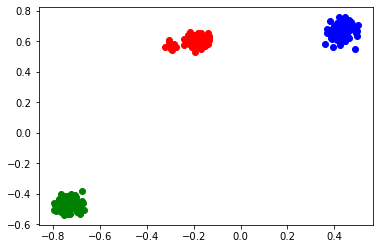

In [108]:
scatterDraw(100, True, False)

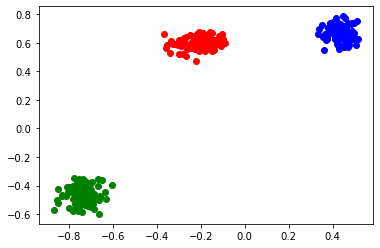

In [109]:
scatterDraw(100, True, True)